In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Set default seaborn style for consistency
sns.set(style="whitegrid")

In [5]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Load the dataset from a CSV file.
    """
    df = pd.read_csv(file_path)
    return df

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the dataframe:
      - Nếu có cột 'trans_time_day', chuyển đổi sang datetime.
      - Nếu có 'trans_time_hrs', chuyển chúng thành số giờ (hoặc dùng trực tiếp).
      - Giữ lại các feature có sẵn và có thể thêm tiền xử lý cho các biến như 'trans_date_is_weekend'.
    """
    if 'trans_time_day' in df.columns:
        df['trans_time_day'] = pd.to_datetime(df['trans_time_day'], errors='coerce')
        # Trích xuất day of week nếu có thể
        df['day_of_week'] = df['trans_time_day'].dt.day_name()
    
    if 'trans_time_hrs' in df.columns:
        # Giả sử trans_time_hrs đã là giá trị số, nếu không chuyển đổi
        df['hour'] = df['trans_time_hrs']
    elif 'trans_time_day' in df.columns:
        # Nếu không có trans_time_hrs, có thể lấy giờ từ trans_time_day
        df['hour'] = df['trans_time_day'].dt.hour
        
    # Các feature khác có thể được xử lý thêm nếu cần
    # Ví dụ: chuyển đổi cột 'trans_date_is_weekend' thành kiểu boolean nếu chưa đúng
    if 'trans_date_is_weekend' in df.columns:
        df['trans_date_is_weekend'] = df['trans_date_is_weekend'].astype(bool)
    
    return df

def dataset_summary(df: pd.DataFrame) -> None:
    """
    In ra tổng số giao dịch, số thẻ tín dụng (cc_num) và tỉ lệ giữa chúng.
    """
    total_transactions = df.shape[0]
    unique_cc_nums = df['cc_num'].nunique() if 'cc_num' in df.columns else 'Unknown'
    rate = total_transactions / unique_cc_nums if isinstance(unique_cc_nums, int) and unique_cc_nums != 0 else None
    
    print("Total number of transactions:", total_transactions)
    print("Total number of unique credit card numbers:", unique_cc_nums)
    if rate is not None:
        print("Rate (total transactions / unique credit card numbers):", rate)

def transaction_analysis(df: pd.DataFrame) -> None:
    """
    Phân tích số giao dịch theo cc_num: in ra cc_num có số giao dịch nhiều nhất và ít nhất.
    """
    if 'cc_num' in df.columns:
        trans_count = df.groupby('cc_num').size()
        max_trans = trans_count.max()
        min_trans = trans_count.min()
        max_cc = trans_count.idxmax()
        min_cc = trans_count.idxmin()
        print("Max transactions:", max_trans, "for cc_num:", max_cc)
        print("Min transactions:", min_trans, "for cc_num:", min_cc)
    else:
        print("Không có cột 'cc_num' trong dataset.")

def transaction_analysis_histogram(df: pd.DataFrame) -> None:
    """
    Vẽ histogram phân phối số giao dịch của mỗi cc_num.
    """
    if 'cc_num' in df.columns:
        trans_count = df.groupby('cc_num').size()
        plt.figure(figsize=(10, 6))
        sns.histplot(trans_count, bins=50, kde=False)
        plt.xlabel("Number of Transactions per Credit Card")
        plt.ylabel("Count of Credit Cards")
        plt.title("Distribution of Transactions per Credit Card")
        plt.tight_layout()
        plt.show()
        
        print(f"Mean transactions per card: {trans_count.mean():.2f}")
        print(f"Median transactions per card: {trans_count.median():.2f}")
        print(f"Max transactions: {trans_count.max()}")
        print(f"Min transactions: {trans_count.min()}")
    else:
        print("Không có cột 'cc_num' trong dataset.")

def transaction_analysis_top_n(df: pd.DataFrame, top_n=20) -> None:
    """
    Vẽ bar chart cho top N cc_num có số giao dịch cao nhất.
    """
    if 'cc_num' in df.columns:
        trans_count = df.groupby('cc_num').size().sort_values(ascending=False)
        top_trans_count = trans_count.head(top_n)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=top_trans_count.index.astype(str), y=top_trans_count.values, palette="viridis")
        plt.xlabel("Credit Card Number (cc_num)")
        plt.ylabel("Number of Transactions")
        plt.title(f"Top {top_n} Credit Cards by Number of Transactions")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        print(f"Max transactions (within top {top_n}): {top_trans_count.max()}")
        print(f"Min transactions (within top {top_n}): {top_trans_count.min()}")
    else:
        print("Không có cột 'cc_num' trong dataset.")

def transaction_analysis_boxplot(df: pd.DataFrame) -> None:
    """
    Vẽ boxplot cho số giao dịch của các cc_num.
    """
    if 'cc_num' in df.columns:
        trans_count = df.groupby('cc_num').size()
        plt.figure(figsize=(6, 6))
        sns.boxplot(y=trans_count.values, color="skyblue")
        plt.ylabel("Number of Transactions")
        plt.title("Box Plot of Transactions per Credit Card")
        plt.tight_layout()
        plt.show()
    else:
        print("Không có cột 'cc_num' trong dataset.")

def fraud_analysis(df: pd.DataFrame) -> None:
    """
    Phân tích giao dịch gian lận theo ngày trong tuần và giờ giao dịch.
    """
    if 'is_fraud' not in df.columns:
        print("Không có cột 'is_fraud' trong dataset.")
        return

    fraud_df = df[df['is_fraud'] == 1]
    
    # Nếu có thông tin day_of_week
    if 'day_of_week' in fraud_df.columns:
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        fraud_day_count = fraud_df['day_of_week'].value_counts().reindex(days_order)
        print("Fraud transactions by day:\n", fraud_day_count)
        plt.figure(figsize=(10, 4))
        sns.barplot(x=fraud_day_count.index, y=fraud_day_count.values, palette="viridis")
        plt.title('Fraud Transactions by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('Number of Fraud Transactions')
        plt.tight_layout()
        plt.show()
    else:
        print("Không có thông tin day_of_week trong dataset.")
    
    if 'hour' in fraud_df.columns:
        fraud_hour_count = fraud_df['hour'].value_counts().sort_index()
        print("\nFraud transactions by hour:\n", fraud_hour_count)
        plt.figure(figsize=(10, 4))
        sns.barplot(x=fraud_hour_count.index, y=fraud_hour_count.values, palette="magma")
        plt.title('Fraud Transactions by Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Number of Fraud Transactions')
        plt.tight_layout()
        plt.show()
    else:
        print("Không có thông tin hour trong dataset.")
    
    # Tính phần trăm gian lận
    total_cc = df['cc_num'].nunique() if 'cc_num' in df.columns else 1
    fraudulent_cc = fraud_df['cc_num'].nunique() if 'cc_num' in fraud_df.columns else 0
    fraud_cc_percent = (fraudulent_cc / total_cc) * 100 if total_cc else 0
    
    total_transactions = df.shape[0]
    fraud_transactions = fraud_df.shape[0]
    fraud_transactions_percent = (fraud_transactions / total_transactions) * 100
    
    print("Unique cc_num with fraud transactions: {} ({:.2f}% of all cc_num)".format(fraudulent_cc, fraud_cc_percent))
    print("Number of fraud transactions: {} ({:.2f}% of all transactions)".format(fraud_transactions, fraud_transactions_percent))

def calculate_time_differences(df: pd.DataFrame) -> pd.DataFrame:
    """
    Tính khoảng cách thời gian giữa các giao dịch của mỗi cc_num.
    Nếu dataset có các biến liên quan đến delta_T hoặc delta_T_minutes, có thể sử dụng chúng.
    Ở đây, ta sẽ tính lại dựa trên 'unix_time' nếu có.
    """
    if 'unix_time' in df.columns and 'cc_num' in df.columns:
        # Giả sử unix_time là timestamp (s)
        df = df.sort_values(by=['cc_num', 'unix_time'])
        df['delta_t_seconds_calc'] = df.groupby('cc_num')['unix_time'].diff().fillna(0)
    else:
        print("Thiếu cột 'unix_time' hoặc 'cc_num' để tính delta_t.")
    return df

def fraud_time_distance_analysis(df: pd.DataFrame, threshold: int = 3600) -> None:
    """
    Phân tích phần trăm giao dịch gian lận có khoảng cách thời gian ngắn (<= threshold) và dài (> threshold).
    """
    df = calculate_time_differences(df)
    if 'is_fraud' not in df.columns or 'delta_t_seconds_calc' not in df.columns:
        print("Không đủ dữ liệu để thực hiện phân tích khoảng cách thời gian.")
        return

    fraud_df = df[df['is_fraud'] == 1]
    short_time_diff = fraud_df[fraud_df['delta_t_seconds_calc'] <= threshold]
    long_time_diff = fraud_df[fraud_df['delta_t_seconds_calc'] > threshold]
    
    short_time_percent = (len(short_time_diff) / len(fraud_df)) * 100 if len(fraud_df) > 0 else 0
    long_time_percent = (len(long_time_diff) / len(fraud_df)) * 100 if len(fraud_df) > 0 else 0
    
    print(f"Percentage of fraud transactions with short time difference (<= {threshold} seconds): {short_time_percent:.2f}%")
    print(f"Percentage of fraud transactions with long time difference (> {threshold} seconds): {long_time_percent:.2f}%")

def fraud_night_analysis(df: pd.DataFrame) -> None:
    """
    Phân tích giao dịch gian lận xảy ra vào ban đêm dựa trên biến 'trans_time_is_night'.
    """
    if 'is_fraud' not in df.columns or 'trans_time_is_night' not in df.columns:
        print("Thiếu cột 'is_fraud' hoặc 'trans_time_is_night'.")
        return
    
    fraud_df = df[df['is_fraud'] == 1]
    total_fraud = fraud_df.shape[0]
    night_fraud = fraud_df[fraud_df['trans_time_is_night'] == 1].shape[0]
    percent_night_fraud = (night_fraud / total_fraud) * 100 if total_fraud > 0 else 0
    
    print(f"Tổng số giao dịch gian lận: {total_fraud}")
    print(f"Số giao dịch gian lận xảy ra vào ban đêm (trans_time_is_night == 1): {night_fraud}")
    print(f"Phần trăm giao dịch gian lận xảy ra vào ban đêm: {percent_night_fraud:.2f}%")

def plot_transaction_time_distribution(df: pd.DataFrame) -> None:
    """
    Vẽ biểu đồ phân phối khoảng cách thời gian giữa các giao dịch tính theo 'delta_t_seconds_calc'.
    """
    if 'delta_t_seconds_calc' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df['delta_t_seconds_calc'], bins=50, kde=True)
        plt.title('Distribution of Time Differences Between Transactions (in seconds)')
        plt.xlabel('Time Difference (seconds)')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    else:
        print("Không tìm thấy cột delta_t_seconds_calc.")

def overall_fraud_distribution(df: pd.DataFrame) -> None:
    """
    Vẽ biểu đồ phân phối giao dịch gian lận so với giao dịch hợp lệ.
    """
    if 'is_fraud' in df.columns:
        fraud_counts = df['is_fraud'].value_counts(normalize=True)
        plt.figure(figsize=(6, 4))
        sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='coolwarm')
        plt.xticks([0, 1], ['Legitimate', 'Fraud'])
        plt.xlabel("Transaction Type")
        plt.ylabel("Proportion")
        plt.title("Transaction Fraud Ratio")
        plt.tight_layout()
        plt.show()
    else:
        print("Không có cột 'is_fraud' trong dataset.")

def top_fraudulent_users(df: pd.DataFrame, top_n: int = 10) -> None:
    """
    Vẽ biểu đồ và in ra top cc_num có số giao dịch gian lận cao nhất.
    """
    if 'is_fraud' in df.columns and 'cc_num' in df.columns:
        fraud_users = df[df['is_fraud'] == 1]['cc_num'].value_counts().head(top_n)
        plt.figure(figsize=(10, 5))
        fraud_users.plot(kind='bar', color='red')
        plt.xlabel("User ID (cc_num)")
        plt.ylabel("Number of Fraudulent Transactions")
        plt.title(f"Top {top_n} Fraudulent Users")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        total_fraud_users = df[df['is_fraud'] == 1]['cc_num'].nunique()
        print("Total users with at least one fraud transaction:", total_fraud_users)
    else:
        print("Thiếu cột 'is_fraud' hoặc 'cc_num' trong dataset.")

def boxplot_transaction_amount(df: pd.DataFrame) -> None:
    """
    Vẽ boxplot so sánh số tiền giao dịch ('amt') giữa giao dịch gian lận và hợp lệ.
    """
    if 'is_fraud' in df.columns and 'amt' in df.columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='is_fraud', y='amt', data=df, palette="coolwarm")
        plt.xlabel("Transaction Type (0: Legitimate, 1: Fraud)")
        plt.ylabel("Transaction Amount")
        plt.title("Transaction Amount Distribution")
        plt.ylim(0, 5000)  # Điều chỉnh nếu cần để giảm ảnh hưởng của outliers
        plt.tight_layout()
        plt.show()
    else:
        print("Thiếu cột 'is_fraud' hoặc 'amt' trong dataset.")

def fraud_by_merchant_and_category(df: pd.DataFrame) -> None:
    """
    Phân tích giao dịch gian lận theo merchant và category nếu các cột này có trong dataset.
    """
    if 'is_fraud' not in df.columns:
        print("Không có cột 'is_fraud' trong dataset.")
        return
    
    fraud_df = df[df['is_fraud'] == 1]
    
    if 'merchant' in fraud_df.columns:
        fraud_by_merchant = fraud_df['merchant'].value_counts().head(10)
        plt.figure(figsize=(10, 5))
        fraud_by_merchant.plot(kind='bar', color='red')
        plt.xlabel("Merchant")
        plt.ylabel("Fraudulent Transaction Count")
        plt.title("Top 10 Merchants by Fraudulent Transactions")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Không có cột 'merchant' trong dataset.")
    
    if 'category' in fraud_df.columns:
        fraud_by_category = fraud_df['category'].value_counts()
        plt.figure(figsize=(10, 5))
        fraud_by_category.plot(kind='bar', color='red')
        plt.xlabel("Category")
        plt.ylabel("Fraudulent Transaction Count")
        plt.title("Fraud Distribution by Category")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Không có cột 'category' trong dataset.")

def fraud_by_state(df: pd.DataFrame) -> None:
    """
    Vẽ bar chart top 10 state có số giao dịch gian lận cao nhất.
    """
    if 'is_fraud' in df.columns and 'state' in df.columns:
        fraud_state = df[df['is_fraud'] == 1]['state'].value_counts().head(10)
        plt.figure(figsize=(10, 5))
        fraud_state.plot(kind='bar', color='red')
        plt.xlabel("State")
        plt.ylabel("Fraudulent Transaction Count")
        plt.title("Top 10 States by Fraudulent Transactions")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Thiếu cột 'is_fraud' hoặc 'state' trong dataset.")

def age_distribution(df: pd.DataFrame) -> None:
    """
    Nếu dataset có cột 'age', vẽ biểu đồ phân phối độ tuổi của các giao dịch gian lận.
    Nếu không, có thể bỏ qua hoặc sử dụng biến khác.
    """
    if 'is_fraud' in df.columns and 'age' in df.columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(df[df['is_fraud'] == 1]['age'], bins=20, kde=True, color='red', label="Fraud")
        if 'cc_num' in df.columns:
            fraud_age_distribution = df[df['is_fraud'] == 1].groupby('age')['cc_num'].nunique()
            top_fraud_ages = fraud_age_distribution.sort_values(ascending=False).head(10)
            bottom_fraud_ages = fraud_age_distribution.sort_values(ascending=True).head(10)
            print("Top 10 Ages with the Most Fraudulent Transactions:")
            print(top_fraud_ages)
            print("\nTop 10 Ages with the Least Fraudulent Transactions:")
            print(bottom_fraud_ages)
        plt.legend()
        plt.xlabel("Age")
        plt.ylabel("Number of Fraudulent Transactions")
        plt.title("Age Distribution for Fraudulent Transactions")
        plt.tight_layout()
        plt.show()
    else:
        print("Thiếu cột 'is_fraud' hoặc 'age' trong dataset.")

def fraud_map_visualization(df: pd.DataFrame) -> folium.Map:
    """
    Tạo bản đồ folium đánh dấu vị trí các giao dịch gian lận dựa trên toạ độ 'merch_lat' và 'merch_long'.
    """
    if 'is_fraud' not in df.columns or ('merch_lat' not in df.columns or 'merch_long' not in df.columns):
        print("Thiếu cột 'is_fraud', 'merch_lat' hoặc 'merch_long' trong dataset.")
        return None

    fraud_df = df[df['is_fraud'] == 1]
    center_lat = df['merch_lat'].mean()
    center_long = df['merch_long'].mean()
    fraud_map = folium.Map(location=[center_lat, center_long], zoom_start=5)
    
    fraud_locations = fraud_df[['merch_lat', 'merch_long']].dropna()
    for _, row in fraud_locations.iterrows():
        folium.CircleMarker(
            location=[row['merch_lat'], row['merch_long']],
            radius=3,
            color="red",
            fill=True,
            fill_color="red"
        ).add_to(fraud_map)
    return fraud_map

def fraud_clustering_kmeans(df: pd.DataFrame, n_clusters=3) -> None:
    """
    Sử dụng K-Means để phân nhóm giao dịch gian lận dựa trên 'amt' và (nếu có) 'age'.
    """
    fraud_df = df[df['is_fraud'] == 1]
    if 'amt' in fraud_df.columns:
        # Nếu có cả 'age', sử dụng 2 feature; nếu không chỉ dùng 'amt'
        features = fraud_df[['amt', 'age']] if 'age' in fraud_df.columns else fraud_df[['amt']]
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        fraud_df['cluster'] = kmeans.fit_predict(scaled_features)
        plt.figure(figsize=(10, 6))
        if 'age' in fraud_df.columns:
            sns.scatterplot(x=fraud_df['amt'], y=fraud_df['age'], hue=fraud_df['cluster'], palette='viridis')
            plt.xlabel('Transaction Amount')
            plt.ylabel('Age')
        else:
            sns.scatterplot(x=fraud_df.index, y=fraud_df['amt'], hue=fraud_df['cluster'], palette='viridis')
            plt.xlabel('Index')
            plt.ylabel('Transaction Amount')
        plt.title(f"K-Means Clustering of Fraudulent Users (n_clusters={n_clusters})")
        plt.tight_layout()
        plt.show()
    else:
        print("Thiếu cột 'amt' trong dataset.")

def fraud_clustering_dbscan(df: pd.DataFrame) -> None:
    """
    Sử dụng DBSCAN để phân nhóm và phát hiện điểm bất thường trong giao dịch gian lận.
    """
    fraud_df = df[df['is_fraud'] == 1]
    if 'amt' in fraud_df.columns:
        features = fraud_df[['amt', 'age']] if 'age' in fraud_df.columns else fraud_df[['amt']]
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        fraud_df['dbscan_cluster'] = dbscan.fit_predict(scaled_features)
        plt.figure(figsize=(10, 6))
        if 'age' in fraud_df.columns:
            sns.scatterplot(x=fraud_df['amt'], y=fraud_df['age'], hue=fraud_df['dbscan_cluster'], palette='magma')
            plt.xlabel('Transaction Amount')
            plt.ylabel('Age')
        else:
            sns.scatterplot(x=fraud_df.index, y=fraud_df['amt'], hue=fraud_df['dbscan_cluster'], palette='magma')
            plt.xlabel('Index')
            plt.ylabel('Transaction Amount')
        plt.title("DBSCAN Clustering of Fraudulent Users")
        plt.tight_layout()
        plt.show()
    else:
        print("Thiếu cột 'amt' trong dataset.")

def fraud_anomaly_detection(df: pd.DataFrame) -> None:
    """
    Sử dụng Isolation Forest để phát hiện giao dịch gian lận có hành vi bất thường dựa trên 'amt' và 'age' (nếu có).
    """
    fraud_df = df[df['is_fraud'] == 1]
    if 'amt' in fraud_df.columns:
        features = fraud_df[['amt', 'age']] if 'age' in fraud_df.columns else fraud_df[['amt']]
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(features)
        iso_forest = IsolationForest(contamination=0.05, random_state=42)
        fraud_df['anomaly'] = iso_forest.fit_predict(scaled_features)
        plt.figure(figsize=(10, 6))
        if 'age' in fraud_df.columns:
            sns.scatterplot(x=fraud_df['amt'], y=fraud_df['age'], hue=fraud_df['anomaly'], palette='coolwarm')
            plt.xlabel('Transaction Amount')
            plt.ylabel('Age')
        else:
            sns.scatterplot(x=fraud_df.index, y=fraud_df['amt'], hue=fraud_df['anomaly'], palette='coolwarm')
            plt.xlabel('Index')
            plt.ylabel('Transaction Amount')
        plt.title("Anomaly Detection in Fraudulent Users using Isolation Forest")
        plt.tight_layout()
        plt.show()
        anomalies = fraud_df[fraud_df['anomaly'] == -1]
        print(f"Number of anomalous fraudulent users detected: {len(anomalies)}")
    else:
        print("Thiếu cột 'amt' trong dataset.")

=== Dataset Summary ===
Total number of transactions: 8580255
Total number of unique credit card numbers: 9968
Rate (total transactions / unique credit card numbers): 860.7799959871589

=== Transaction Analysis ===
Max transactions: 2205 for cc_num: 4521642011808293
Min transactions: 7 for cc_num: 501816096629


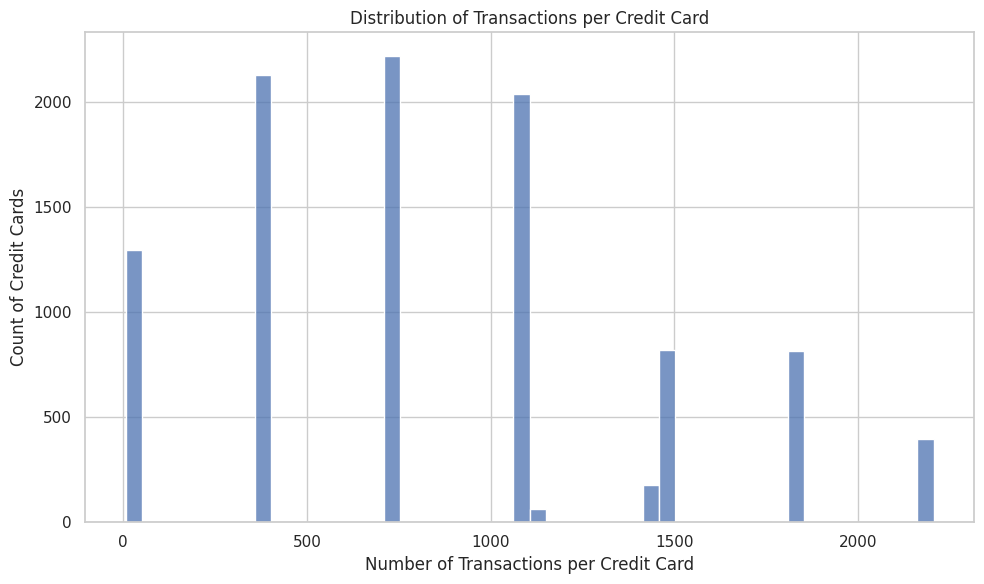

Mean transactions per card: 860.78
Median transactions per card: 737.00
Max transactions: 2205
Min transactions: 7


/tmp/ipykernel_1837456/554967524.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_trans_count.index.astype(str), y=top_trans_count.values, palette="viridis")


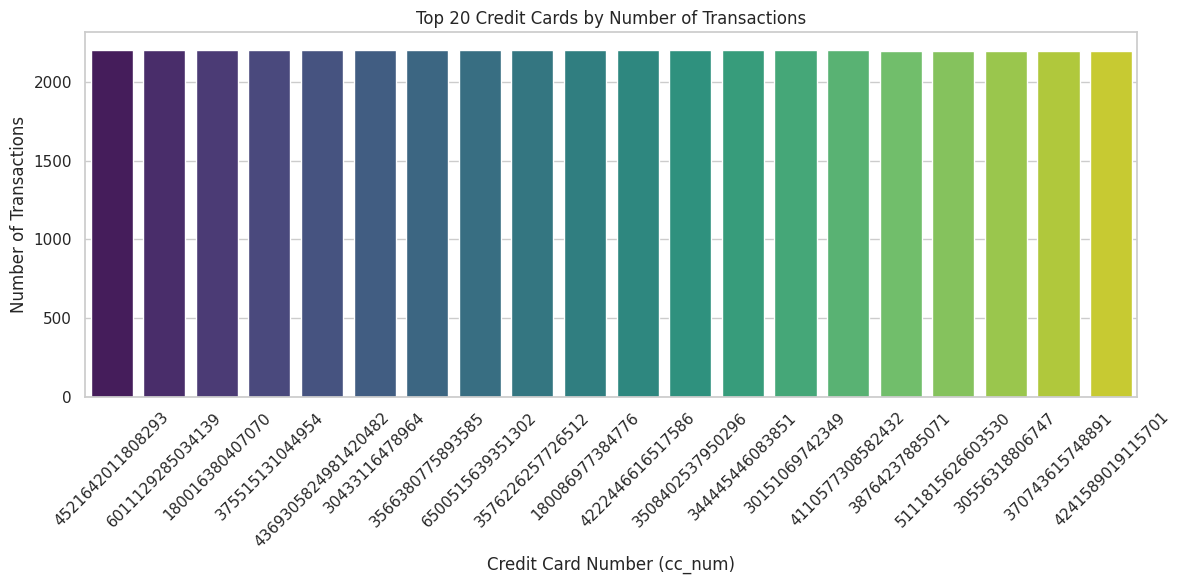

Max transactions (within top 20): 2205
Min transactions (within top 20): 2199


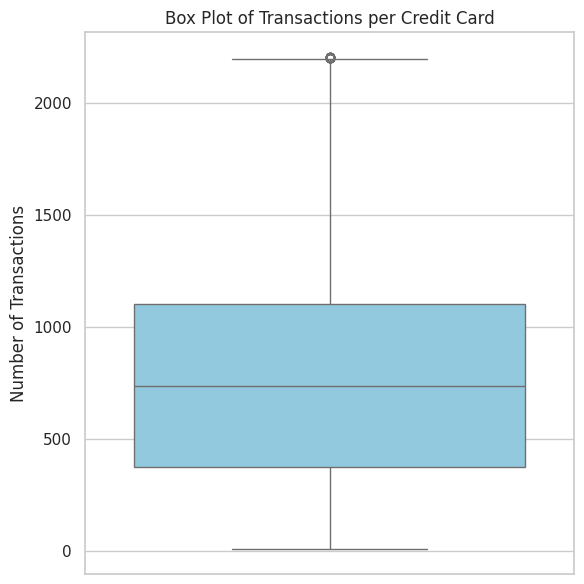


=== Fraud Analysis ===
Fraud transactions by day:
 day_of_week
Monday           NaN
Tuesday          NaN
Wednesday        NaN
Thursday     94806.0
Friday           NaN
Saturday         NaN
Sunday           NaN
Name: count, dtype: float64


/tmp/ipykernel_1837456/554967524.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_day_count.index, y=fraud_day_count.values, palette="viridis")


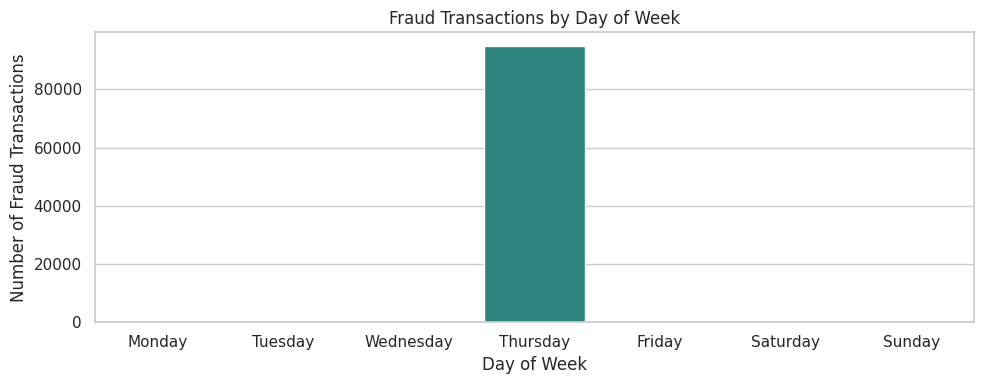


Fraud transactions by hour:
 hour
0     4061
1     3904
2     3912
3     3989
4     3921
5     3855
6     3990
7     3867
8     3966
9     3987
10    4026
11    4017
12    4007
13    3944
14    3905
15    3995
16    3914
17    3987
18    3996
19    3865
20    3850
21    3961
22    3944
23    3943
Name: count, dtype: int64


/tmp/ipykernel_1837456/554967524.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_hour_count.index, y=fraud_hour_count.values, palette="magma")


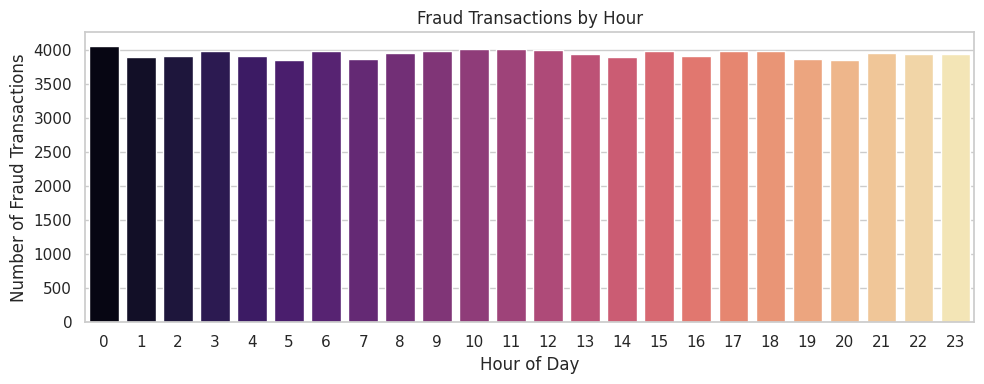

Unique cc_num with fraud transactions: 9793 (98.24% of all cc_num)
Number of fraud transactions: 94806 (1.10% of all transactions)


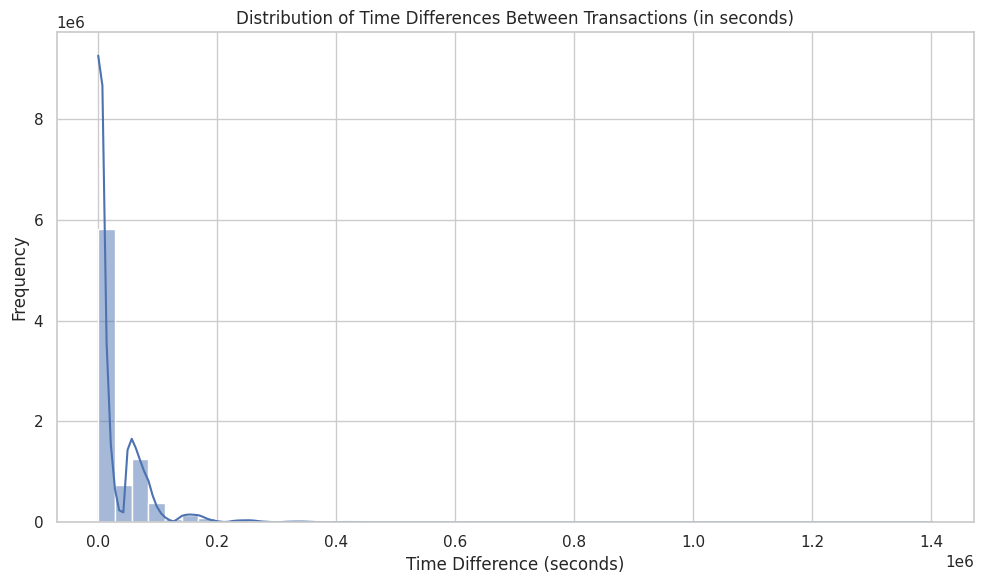

Percentage of fraud transactions with short time difference (<= 3600 seconds): 52.50%
Percentage of fraud transactions with long time difference (> 3600 seconds): 47.50%
Tổng số giao dịch gian lận: 94806
Số giao dịch gian lận xảy ra vào ban đêm (trans_time_is_night == 1): 27714
Phần trăm giao dịch gian lận xảy ra vào ban đêm: 29.23%


/tmp/ipykernel_1837456/554967524.py:241: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='coolwarm')


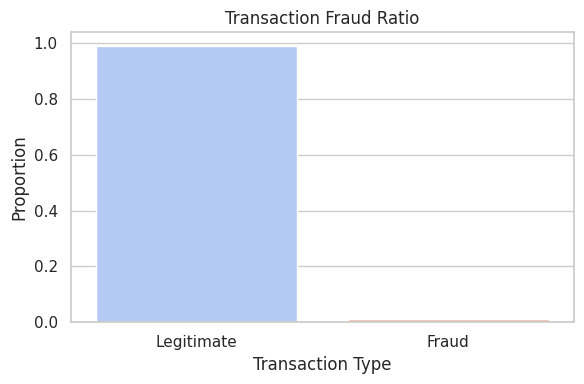

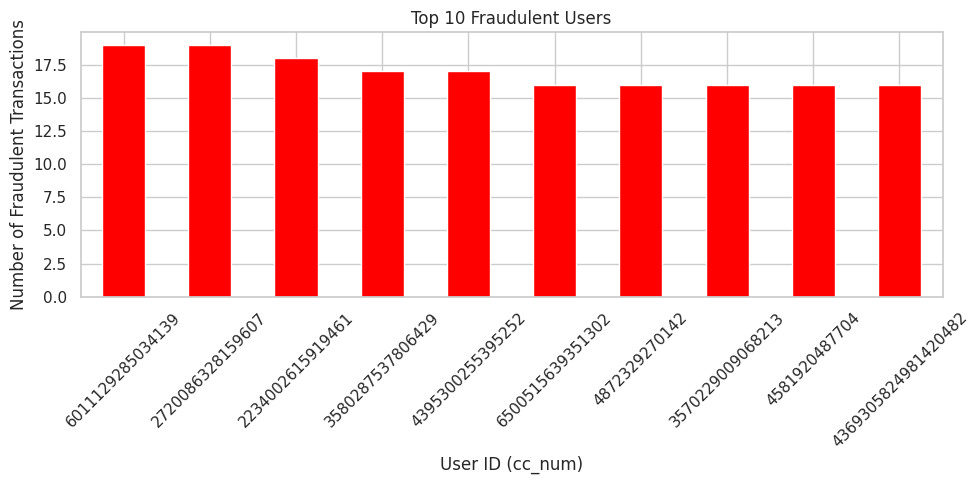

Total users with at least one fraud transaction: 9793


/tmp/ipykernel_1837456/554967524.py:277: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y='amt', data=df, palette="coolwarm")


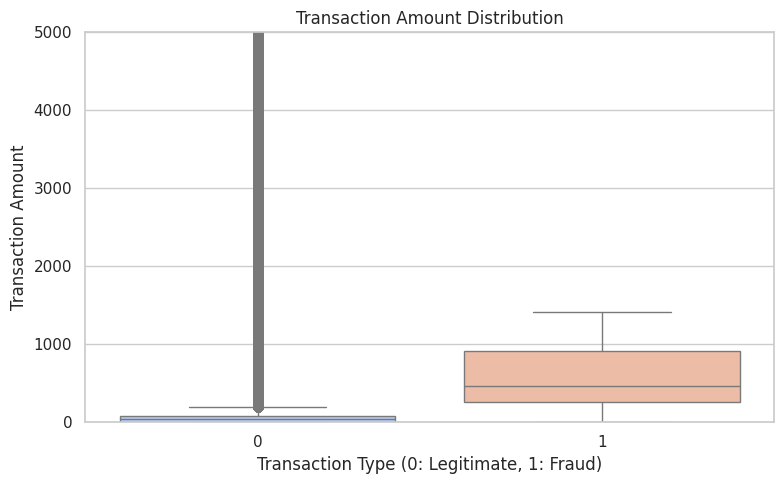

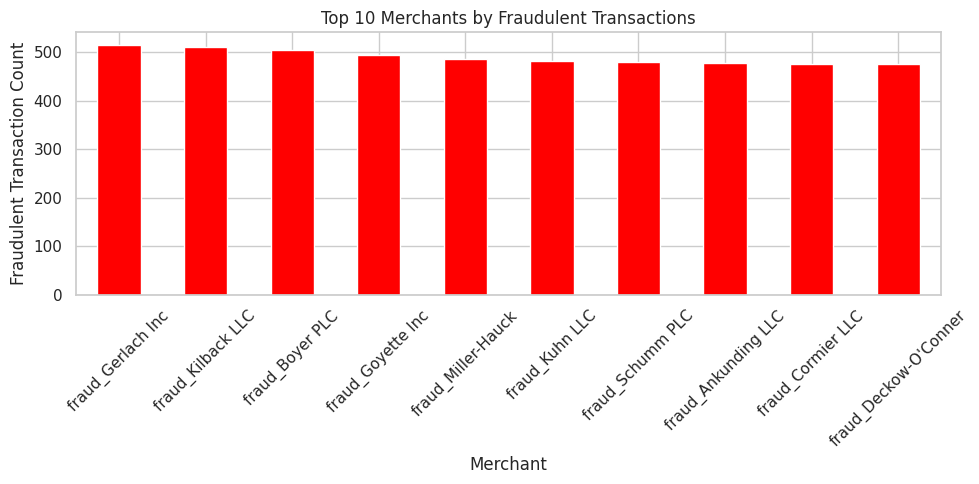

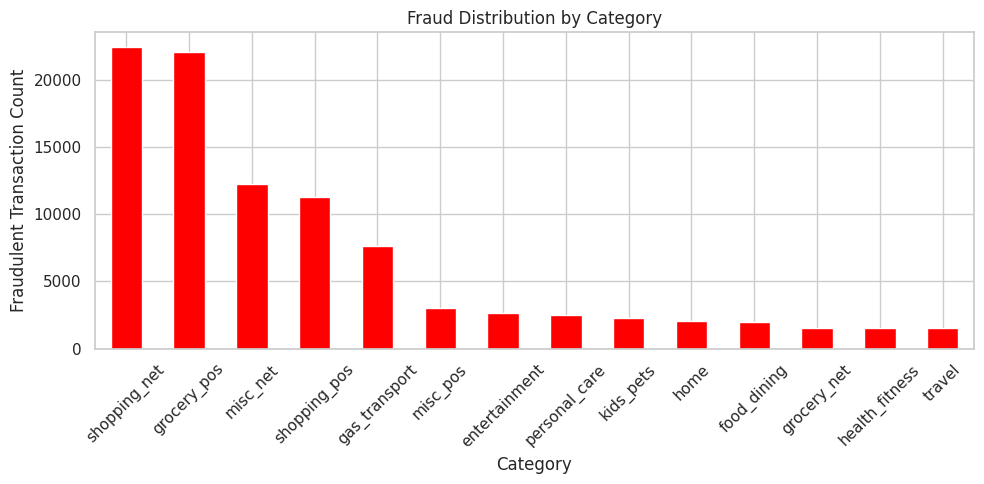

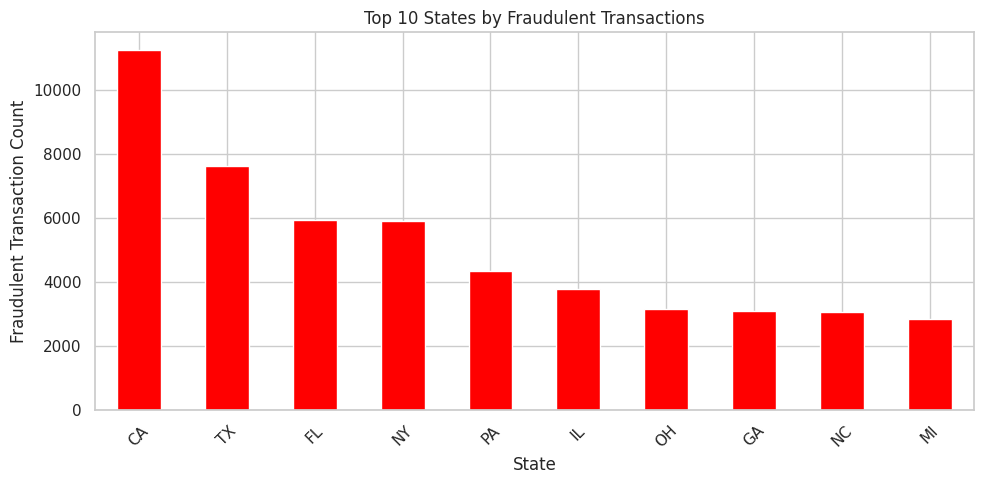

Thiếu cột 'is_fraud' hoặc 'age' trong dataset.

=== Fraud Clustering using K-Means ===


/tmp/ipykernel_1837456/554967524.py:400: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['cluster'] = kmeans.fit_predict(scaled_features)


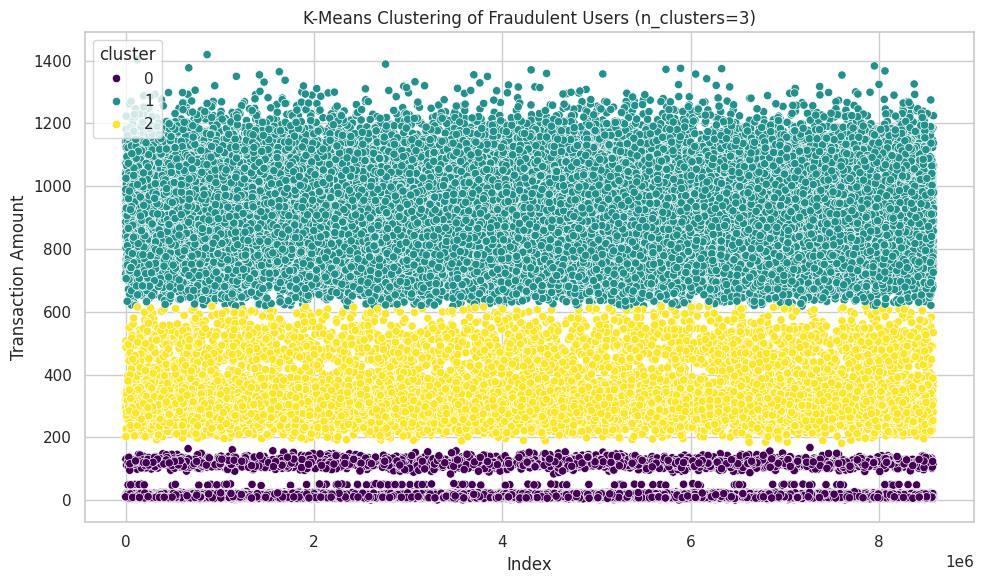


=== Fraud Clustering using DBSCAN ===


/tmp/ipykernel_1837456/554967524.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['dbscan_cluster'] = dbscan.fit_predict(scaled_features)


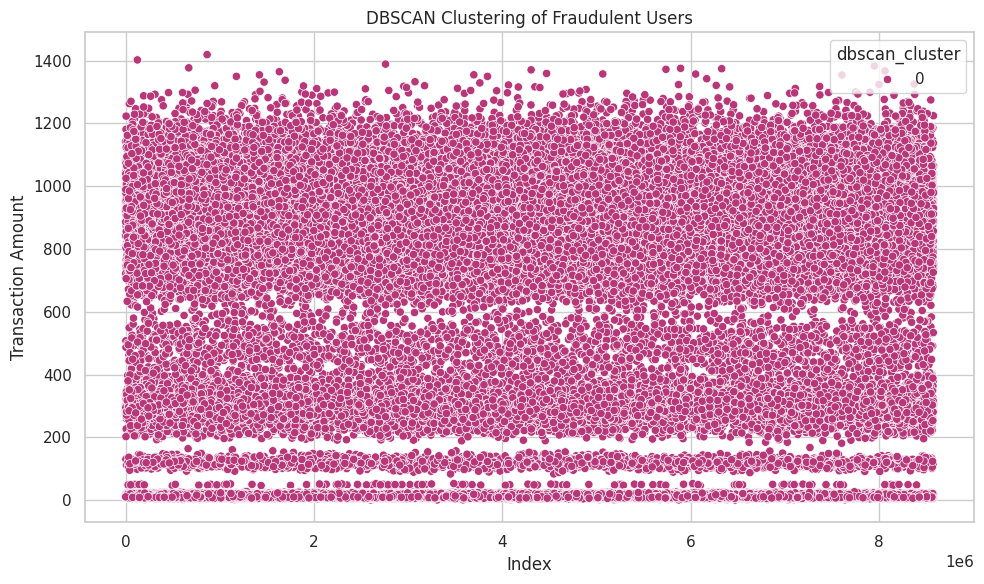


=== Fraud Anomaly Detection ===


/tmp/ipykernel_1837456/554967524.py:452: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['anomaly'] = iso_forest.fit_predict(scaled_features)


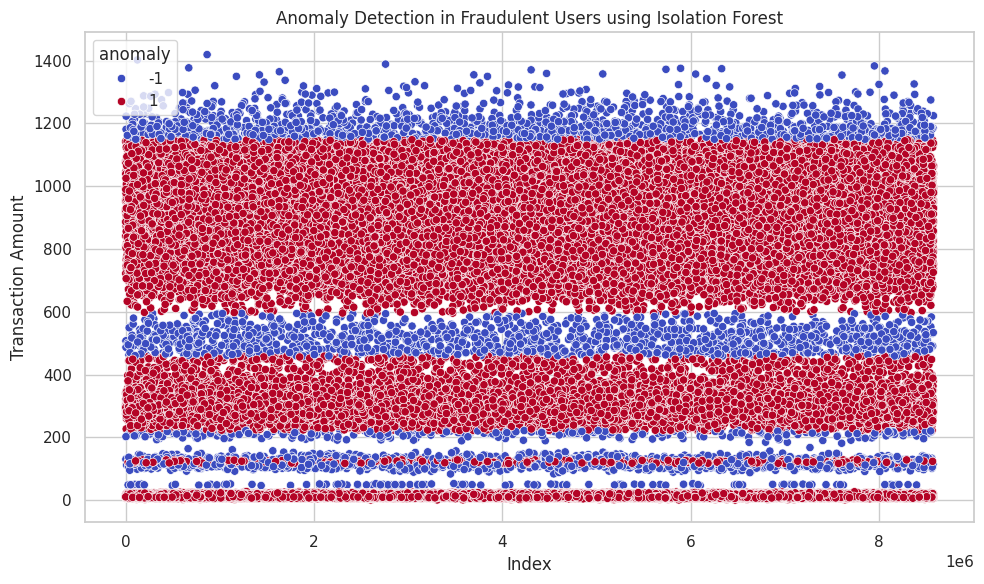

Number of anomalous fraudulent users detected: 4723
Columns with missing values:
 Series([], dtype: int64)


In [7]:
def main():
    # Đường dẫn đến dataset của bạn
    file_path = "/home/ducanh/Financial Risk & Fraud Detection/Credit Card Fraud Detection/Datasets/CCFD/CCFD_Data_3Gb.csv"
    
    # Load và tiền xử lý dữ liệu
    df = load_data(file_path)
    df = preprocess_data(df)
    print("=== Dataset Summary ===")
    dataset_summary(df)
    
    print("\n=== Transaction Analysis ===")
    transaction_analysis(df)
    transaction_analysis_histogram(df)
    transaction_analysis_top_n(df)
    transaction_analysis_boxplot(df)
    
    print("\n=== Fraud Analysis ===")
    fraud_analysis(df)
    df = calculate_time_differences(df)
    plot_transaction_time_distribution(df)
    fraud_time_distance_analysis(df, threshold=3600)
    fraud_night_analysis(df)
    overall_fraud_distribution(df)
    top_fraudulent_users(df)
    boxplot_transaction_amount(df)
    fraud_by_merchant_and_category(df)
    fraud_by_state(df)
    age_distribution(df)
    
    print("\n=== Fraud Clustering using K-Means ===")
    fraud_clustering_kmeans(df, n_clusters=3)
    
    print("\n=== Fraud Clustering using DBSCAN ===")
    fraud_clustering_dbscan(df)
    
    print("\n=== Fraud Anomaly Detection ===")
    fraud_anomaly_detection(df)
    
    # Lưu giao dịch gian lận vào CSV nếu cần
    if 'is_fraud' in df.columns:
        df[df['is_fraud'] == 1].to_csv('/home/ducanh/Financial Risk & Fraud Detection/Credit Card Fraud Detection/EDA/fraud_transactions_CCFD.csv', index=False)
    
    missing_values = df.isnull().sum()
    print("Columns with missing values:\n", missing_values[missing_values > 0])
    
    # Tạo và trả về bản đồ giao dịch gian lận
    fraud_map = fraud_map_visualization(df)
    return fraud_map

if __name__ == "__main__":
    fraud_map = main()